# INF200 Lecture No 10

###  16 November 2020

## Today's topics

1. Review Assignment 5
1. Optimization
    1. Algorithm analysis
    1. Benchmarking
    1. Profiling
1. Some practical approaches
    1. Use local variables
    1. Use arrays and canned methods (NumPy, SciPy)
1. Compiled Python Code
    1. Numba
    1. Cython

    
### Note

The precise results of the benchmarks given in this notebook will vary depending on computer type and load. The factors describing differences in runtime are therefore only approximations.

----------

### Review Assignment 5

----------------------

## Optimizing Code

One of the key ideas of Agile programming is to proceed as follows (Kent Beck):

1. Get it to work
1. Get it right
1. Get it fast

We have looked at the first two points, now we will turn to getting code fast.

### Why make it fast?
- Users do not like to wait: fast response times
    - E.g. Google: 10x faster than [AltaVista](https://en.wikipedia.org/wiki/AltaVista) and better results
    - Extreme case: [High-frequency trading](https://en.wikipedia.org/wiki/High-frequency_trading) on the stock market
- Science and engineering
    - Short turn-around times allow more experiments
    - Simulation experiments using months or years are often not useful
- Classic example: [US Census](http://www.census.gov/history/www/census_then_now/notable_alumni/herman_hollerith.html)
    - Performed every 10 years (required by US Constitution)
    - 1880 census was only completely evaluated in 1887
    - 1888 competition for automated tabulation
    - Won by Hermann Hollerith, used in 1890 census
    - Machines also used in 1891 Norwegian census
    - Developed into IBM
    
### How to make it fast?
- Use faster hardware
    - Can be costly
    - Not always available
    - Competition will also use faster hardware, so just faster hardware may not be enough
- Improve your software
    - Better algorithms
    - Smarter data structures
    - 90—10 rule: typically, 90% of the time is spent in 10% of the code
- Change your approach
    - An entirely different strategy may provide faster or better results
    
### The pitfalls of optimization
- Wasting time on the wrong things
    - Donald Knuth: "We should forget about small efficiencies, say about 97% of the time: premature optimization is the root of all evil." [Wikipedia](https://en.wikipedia.org/wiki/Program_optimization)
- Trade-offs
    - "There is no such thing as a free lunch"
    - Memory: faster algorithms may need more
    - Flexibility: by limiting what code can do, we may make it faster
    - Portability: fine-tuning may make code faster on one machine, but it may no longer run on others
- Correctness
    - Optimization means changing code
    - Changes may break code
    - A thorough test regime needs to be in place *before* optimizing

## Algorithm analysis

### Summing numbers

Task: Compute the sum of all natural numbers up to $n$, i.e., $\sum_{k=1}^{n} k$.

#### Implementations

##### Loop

In [1]:
def sum_n_loop(n):
    s = 0
    for k in range(1, n+1):
        s += k
    return s

##### List comprehension

In [2]:
def sum_n_comp(n):
    return sum(range(1, n+1))

#### Tests

In [3]:
funcs = [sum_n_loop, sum_n_comp]
for func in funcs:
    assert func(1) == 1
    assert func(2) == 3
    assert func(3) == 6

#### Analysis

- How many operations are needed to complete the calculation?
- $n$ loop iterations
    - For each loop iteration
        - $1$ addition
        - $1$ step of the loop counter $k$
- Some operations to start function and return value
- Model of operation count
    - $a$ operations outside loop
    - $b$ operations inside loop for each iteration
    - $\Rightarrow a + b n$ operations
- Rough assumptions
    - All operations take the same time $c$
    - Then total time required: $T(n) \approx c(a+bn)$
    - For $n\gg 1$ we can ignore the constant, so $T(n)\sim n$ 
- The algorithm is *linear* in problem size
- In algorithm analysis, we say that the run-time is of order $n$, $T(n)=\Theta(n)$
- For details, take *INF221 Computer Science for Data Scientists*
    - [Course description](https://www.nmbu.no/course/INF221)
    - [INF221 on Canvas](https://nmbu.instructure.com/courses/3048)

#### Algorithmic improvement

- From mathematics: $$\sum_{k=1}^n k = \frac{n(n+1)}{2}$$

##### Implementation based on analytical solution

In [4]:
def sum_n_ana(n):
    return (n * (n + 1)) / 2

##### Analysis of analytical-solution algorithm

- One addition, one multiplication, on division by $2$ *independent of problem size*
- $\Rightarrow T(n) = \mathrm{const}$ or $T(n)=\Theta(1)$
- Signficant improvement for $n\gg 1$
- Weaknesses
    - operations are only constant in time as long as integer type is fixed size
    - therefore, the analysis above holds strictly only up to a certain $n$

##### Re-run tests for all solutions

In [5]:
funcs = [sum_n_loop, sum_n_comp, sum_n_ana]
for func in funcs:
    assert func(1) == 1
    assert func(2) == 3
    assert func(3) == 6

### Sorting algorithms

Let us have quick look at sorting algorithms.

#### Bubble sort

- Slightly modified from exercise
    - data sorted in-place
    - outer loop index now running backward to make analysis easier

In [6]:
def bubble_sort(data):
    n = len(data)
    for j in range(n-1, 0, -1):
        for k in range(j):
            if data[k] > data[k + 1]:
                data[k], data[k + 1] = data[k + 1], data[k]

- Outer loop: $n-1$ iterations
- Inner loop: $j$ iterations
    - $1$ comparison
    - possibly $1$ swap
- Total number of inner-loop iterations: 
  $$\sum_{j=1}^{n-1} j=\frac{n(n-1)}{2}\sim n^2 \quad \text{for} \; n\gg 1$$
- Algorithm's run-time is *quadratic* in problem size, $T(n)\sim n^2$ or $T(n)=\Theta(n^2)$

#### Quicksort

- Divide-and-conquer sorting algorithm: subdivide sort into smaller and smaller tasks
- Invented by [C.A.R. Hoare](https://en.wikipedia.org/wiki/Tony_Hoare) around 1959
- Still one of the most used sorting algorithms
- See e.g. [Wikipedia](https://en.wikipedia.org/wiki/Quicksort)
- Basic idea:
    1. Choose a pivot element from the data
    1. Re-order data so that
        - all elements smaller than pivot are left of the pivot
        - all elements larger than pivot are right of the pivot
    1. Apply recursively on left and right side

In [7]:
def quicksort(data):
    _quicksort(data, 0, len(data))

def _quicksort(data, left, right):
    if right - left < 2:
        return

    pivot_idx = _partition(data, left, right)
    _quicksort(data, left, pivot_idx)
    _quicksort(data, pivot_idx + 1, right)

def _partition(data, left, right):
    if not left < right:
        return None

    right -= 1  
    pivot_idx = left
    pivot_val = data[pivot_idx]

    data[pivot_idx], data[right] = data[right], data[pivot_idx]
    store_idx = left

    for i in range(left, right):
        if data[i] < pivot_val:
            data[i], data[store_idx] = data[store_idx], data[i]
            store_idx += 1
    data[store_idx], data[right] = data[right], data[store_idx]

    return store_idx

- All work is done in `_partition`
    - one loop of length `right-left` or $n = r-l$
- How do $l$ and $r$ change as recursion progresses?
- Best case:
    - pivot splits data in half every time `_partition()` is called
    - then during recursion: $n \rightarrow n/2 \rightarrow n/4 \rightarrow \dots 1$
    - number of recursions required: $\log_2 n$
    - how often is `_partition` called?
        - top level: 1 time, data length $n$
        - first recursion: 2 times, data length $n/2$ for each
        - second recursion: 4 times, data length $n/4$ for each
        - ...
    - the total number of loop iterations is thus $n$ for each recursion level
    - $\Rightarrow \approx n \log_2 n$ loop iterations
    - Therefore, $T(n) \sim n\log n$ or $T(n)=\Omega(n\log n)$
- Worst case:
    - the first element is the pivot on each recursion
    - each call to `_partition()` returns one empty segement and one segment shorter by 1 only
    - number of recursions required: $n-1$
    - $\Rightarrow \approx n^2$
    - Therefore $T(n) \sim n^2$ or $T(n)=O(n^2)$
    - The algorithm is *quadratic*
- Illustrates importance of considering *best case*, *worst case* and *average case*.

##  Benchmarking: Empirical performance testing

- Also known as *benchmarking*
- Systematic testing of software performance
- Mostly speed, but also memory and increasingly energy consumption

### Timing code

- Code timing and profiling are *experiments*
- Subject to external disturbance, e.g., other activity on computer
- Results may depend on system used, both hardware and software: good documentation essential
- Timing/profiling runs must be done with realistic loads and last long enough ($>1$s), otherwise, you measure noise
- Many advanced profiling tools exploit special information from CPUs, but we won't discuss that here

#### Basic timing with `timeit`

- Jupyter magic automatically adjust number of repetitions
- We look at best results from N repetitions, since all slower results must be due to other activity in machine
- Still a good idea to repeat the same measurement several times


In [8]:
%timeit sum_n_loop(1000000)
%timeit sum_n_loop(1000000)
%timeit sum_n_loop(1000000)

46.3 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
48 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.3 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit sum_n_comp(1000000)
%timeit sum_n_comp(1000000)
%timeit sum_n_comp(1000000)

12.2 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.1 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.2 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


- We see some variation in run-times between repetitions
- Note that timeit automatically adjust the number of loops to ensure reliable results

In [10]:
%timeit sum_n_ana(1000000)
%timeit sum_n_ana(1000000)
%timeit sum_n_ana(1000000)

116 ns ± 2.7 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
116 ns ± 2.43 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
116 ns ± 3.56 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


- Analytical approch is more that 100.000 times faster!

### Manual benchmarks

#### Check for correctness

- Before benchmarking, make sure that algorithms work correctly

In [11]:
import numpy as np

In [12]:
test_data = np.random.random(1000)
bs_data = test_data.copy()
qs_data = test_data.copy()

bubble_sort(bs_data)
quicksort(qs_data)

assert all(bs_data[:-1] <= bs_data[1:])
assert all(qs_data[:-1] <= qs_data[1:])

- Looks fine, in real life we should test more extensively.

#### First attempt

In [13]:
bs_data = test_data.copy()
%timeit bubble_sort(bs_data)

123 ms ± 4.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
qs_data = test_data.copy()
%timeit quicksort(qs_data)

65.6 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Quicksort is faster than bubble sort, as expected
- Are the results really plausible?
    - Bubble sort is $\Theta(n^2) = c_{\text{bs}}\times 1000^2$
    - Quicksort in normal case is $\Omega(n\log_2 n) = c_{\text{qs}}\times 1000 \times \log_2 1000 \approx c_{\text{qs}}\times 1000 \times 10$
    - Would expect a factor near 100, got less than factor 2
    - Some of this can be explained by $c_{\text{qs}} > c_{\text{bs}}$
- What did we do wrong?

- Running quicksort on sorted data leads to worst case!
- `%timeit` runs sorting many times over
- We sort *in place*
- All except the first run is on sorted data!
- Solution: provide fresh data for each run

In [15]:
%timeit quicksort(test_data.copy())

3.99 ms ± 52 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%timeit bubble_sort(bs_data.copy())

118 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Quicksort now much faster
- Approximately 30 times faster than bubble sort, right order of magnitude
- Compare to Python's and NumPy's built-in sort functions 

In [17]:
%timeit sorted(test_data.copy())

259 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%timeit test_data.copy().sort()

13.7 µs ± 344 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


- Python `sorted()` is more than 15 times faster than quicksort
- NumPy `array.sort()` is another 17 times faster—Why?
    - Python `sorted()` is general for anything that can be sorted
    - NumPy `array.sort()` knows exactly what to sort

#### Scaling

- How does run-time change with problem size?
- Ususally tested with logarithmically-spaced data sizes
- We generate test data and benchmark bubble sort and quicksort
- Since we want to collect timing information, the `%timeit` magic is not useful
- Use `timeit` module
- Use Python's `copy.copy` to copy data before sort so that it works for any iterable data type, not just NumPy arrays

In [19]:
import timeit
import copy

In [20]:
def time_sort(sort_func, data, num_reps=1):
    """
    Returns times for repeated execution of sort_func(data).
    
    Automatically selects number of loops so execution takes
    at least 0.2 s.
    
    :param sort_func: sorting function to test
    :param data: data to sort
    :param num_reps: number of experiment repetitions
    """
    
    # Create Timer object; only objects named in globals are accessible 
    # to statement being timed
    timer = timeit.Timer('s_func(c_func(o_data))',
                         globals={'s_func': sort_func, 
                                  'c_func': copy.copy,
                                  'o_data': data})
    
    # Find out how many loops we need to run for > 0.2 s
    n_loops, t = timer.autorange()
    
    # Perform n_loops for each of num_reps repeats
    return np.array(timer.repeat(number=n_loops, repeat=num_reps)) / n_loops

#### Check that function gives consistent results with those above

In [21]:
time_sort(quicksort, test_data, num_reps=3)

array([0.00389145, 0.00384574, 0.00395149])

- Looks good, about 5 ms

#### Create test data of different lengths

In [22]:
data_length = [2**n for n in range(1, 17, 2)]
bench_data = [np.random.random(dl) for dl in data_length]
num_reps = 3

#### Create DataFrame to hold results

In [23]:
import pandas as pd

In [24]:
times = pd.DataFrame(columns=['Rep', 'Bubble', 'Quick', 'Python', 'NumPy'],
                     index=[dl for dl in data_length for _ in range(num_reps)])
times.Rep = list(range(num_reps)) * len(data_length)
times.head()

Rep Bubble Quick Python NumPy
2    0    NaN   NaN    NaN   NaN
2    1    NaN   NaN    NaN   NaN
2    2    NaN   NaN    NaN   NaN
8    0    NaN   NaN    NaN   NaN
8    1    NaN   NaN    NaN   NaN

#### Run benchmarks

- Start with small sizes
- If a benchmark takes too long, skip benchmarks for larger sizes for that algorithm

In [25]:
for sfunc, name in [(bubble_sort, 'Bubble'),
                    (quicksort, 'Quick'),
                    (sorted, 'Python'),
                    (lambda x: x.sort(), 'NumPy')]:
    for dlen, data in zip(data_length, bench_data):
        print(name[0], end='')
        res = time_sort(sfunc, data, num_reps=num_reps)
        if 10 * max(res) > 1:
            break
        times.loc[dlen, name] = res

BBBBBBQQQQQQQQPPPPPPPPNNNNNNNN

In [26]:
times.head()

Rep       Bubble        Quick       Python        NumPy
2    0  1.48562e-06   2.7844e-06  1.50049e-06  1.00601e-06
2    1  1.62006e-06  2.70793e-06  1.45512e-06  1.08637e-06
2    2  1.66625e-06  2.52761e-06   1.4437e-06   9.9606e-07
8    0  1.87118e-05  1.48581e-05  2.12759e-06  1.01004e-06
8    1  1.85819e-05  1.47104e-05  2.15285e-06  1.02224e-06

#### Plot results

- Linear and double-logarithmic plot
- Take mininmum across repetitions for each case

In [27]:
import matplotlib.pyplot as plt

In [28]:
def plot_comparison(ax, name, func, func_text):
    line = [l for l in ax.lines if l.get_label() == name][0]

    x = line.get_xdata()
    y = line.get_ydata()
    max_ix = y.argmax()
    y_func = y[max_ix] / func(x[max_ix]) * func(x)

    color = line.get_color()
    ax.plot(x, y_func, color=color, linewidth=10, alpha=0.3, label=func_text)

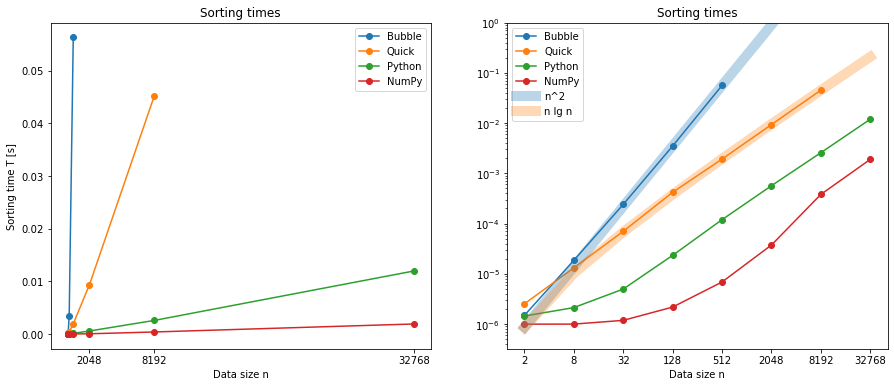

In [29]:
times_min = times.groupby(times.index).min().loc[:, 'Bubble':]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6));
times_min.plot(ax=ax1, title='Sorting times', style='o-');
ax1.set_xlabel('Data size n');
ax1.set_ylabel('Sorting time T [s]');
ax1.set_xticks(data_length[-3:]);

l2 = times_min.plot(ax=ax2, title='Sorting times', style='o-', loglog=True);
plot_comparison(ax2, 'Bubble', lambda n: n**2, 'n^2');
plot_comparison(ax2, 'Quick', lambda n: n * np.log2(n), 'n lg n');
ax2.set_ylim(None, 1);
ax2.set_xlabel('Data size n');
ax2.set_xticks(data_length);
ax2.set_xticklabels(data_length);
ax2.tick_params(axis='x', which='minor', bottom=False)
ax2.legend();

- Results fit well with expectations for large enough data size.
- To really verify that quicksort and built-in sorting follow $n \log n$, we would need use significantly larger data
- Built-in and especially NumPy sort show clearly different behavior for small data sizes
    - Most likely cache effects

-------------------------

## Profiling

- *Profiling* is the systematic investigation of *where* programs spend there time.
- You should always profile before optimizing: most guesses about where time is spent are wrong
- Experience shows that 10% of the code consume 90% of the time: focus on those 10%



### Profiling by function

- Profiling by function shows us how much time is spent in each function
- Supported in Python by [cProfile](https://docs.python.org/3.6/library/profile.html) package

In [30]:
import cProfile
cProfile.run('quicksort([6, 4, 3, 8, 3, 10])')

         18 function calls (10 primitive calls) in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-7-3d84b2c98247>:1(quicksort)
        4    0.000    0.000    0.000    0.000 <ipython-input-7-3d84b2c98247>:12(_partition)
      9/1    0.000    0.000    0.000    0.000 <ipython-input-7-3d84b2c98247>:4(_quicksort)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




- Running on such a small example gives very little information
- We can see that `_partition` was called 4 times
- `_quicksort` was called 9 times, in total, 1 time non-recursively 

In [31]:
data = np.random.random(1000000)
cProfile.run('quicksort(data.copy())')

         2000146 function calls (666720 primitive calls) in 9.343 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    9.339    9.339 <ipython-input-7-3d84b2c98247>:1(quicksort)
   666713    8.807    0.000    8.807    0.000 <ipython-input-7-3d84b2c98247>:12(_partition)
1333427/1    0.532    0.000    9.339    9.339 <ipython-input-7-3d84b2c98247>:4(_quicksort)
        1    0.000    0.000    9.343    9.343 <string>:1(<module>)
        1    0.000    0.000    9.343    9.343 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.004    0.004    0.004    0.004 {method 'copy' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




#### What does this data show us ?
- Note: precise numbers may differ below due to re-runs of the profile
- `ncalls`: number of calls
    - for `_quicksort`, the one call is not recursive, all others recursive
    - the number of recursive `_quicksort` calls is twice the number of `_partition` calls
    - these numbers are consistent with our reading of the code
- `tottime`: total time spent in a function
    - 8.2s were spent in `_partition`, about 94% of the total run time
    - 0.5s were spent in `_quicksort`
- `percall`: time spent in function during a single call
- `cumtime`: time spent by a function and all functions calling it
    - 8.669s: "module" is our call to quicksort
    - 8.665s: `quicksort(data)`
    - 8.665s: `_quicksort()`
    - 8.207s: `_partition()`
        
#### Other  ways of profiling
- Profile in PyCharm
- Use the `%prun` magic in a notebook

In [32]:
data = np.random.random(100000)
%prun quicksort(data.copy())

         199993 function calls (66669 primitive calls) in 0.853 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    66662    0.802    0.000    0.802    0.000 <ipython-input-7-3d84b2c98247>:12(_partition)
 133325/1    0.051    0.000    0.853    0.853 <ipython-input-7-3d84b2c98247>:4(_quicksort)
        1    0.000    0.000    0.000    0.000 {method 'copy' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.853    0.853 {built-in method builtins.exec}
        1    0.000    0.000    0.853    0.853 <string>:1(<module>)
        1    0.000    0.000    0.853    0.853 <ipython-input-7-3d84b2c98247>:1(quicksort)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

    
#### Pstats
- We can get information in different formats by writing data to file and then analysing it with the `pstats` package

In [33]:
data = np.random.random(500000)
cProfile.run('quicksort(data.copy())', 'quicksort.prof')

In [34]:
import pstats
p = pstats.Stats('quicksort.prof');   # reads data from file
p = p.strip_dirs();                   # remove directory information from file names
p.print_stats();                      # print statistics

Fri Nov 20 15:31:51 2020    quicksort.prof

         999103 function calls (333039 primitive calls) in 4.581 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    4.581    4.581 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.002    0.002    0.002    0.002 {method 'copy' of 'numpy.ndarray' objects}
        1    0.000    0.000    4.579    4.579 <ipython-input-7-3d84b2c98247>:1(quicksort)
   333032    4.325    0.000    4.325    0.000 <ipython-input-7-3d84b2c98247>:12(_partition)
 666065/1    0.253    0.000    4.578    4.578 <ipython-input-7-3d84b2c98247>:4(_quicksort)
        1    0.000    0.000    4.581    4.581 <string>:1(<module>)




##### Choose sorting criterium

In [35]:
p.sort_stats('cumulative').print_stats();  # print sorted by cumulative time

Fri Nov 20 15:31:51 2020    quicksort.prof

         999103 function calls (333039 primitive calls) in 4.581 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    4.581    4.581 {built-in method builtins.exec}
        1    0.000    0.000    4.581    4.581 <string>:1(<module>)
        1    0.000    0.000    4.579    4.579 <ipython-input-7-3d84b2c98247>:1(quicksort)
 666065/1    0.253    0.000    4.578    4.578 <ipython-input-7-3d84b2c98247>:4(_quicksort)
   333032    4.325    0.000    4.325    0.000 <ipython-input-7-3d84b2c98247>:12(_partition)
        1    0.002    0.002    0.002    0.002 {method 'copy' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




##### Print who has called which function how often

In [36]:
p.print_callers();

   Ordered by: cumulative time

Function                                          was called by...
                                                      ncalls  tottime  cumtime
{built-in method builtins.exec}                   <- 
<string>:1(<module>)                              <-       1    0.000    4.581  {built-in method builtins.exec}
<ipython-input-7-3d84b2c98247>:1(quicksort)       <-       1    0.000    4.579  <string>:1(<module>)
<ipython-input-7-3d84b2c98247>:4(_quicksort)      <-       1    0.000    4.578  <ipython-input-7-3d84b2c98247>:1(quicksort)
                                                    666064/2    0.253    4.339  <ipython-input-7-3d84b2c98247>:4(_quicksort)
<ipython-input-7-3d84b2c98247>:12(_partition)     <-  333032    4.325    4.325  <ipython-input-7-3d84b2c98247>:4(_quicksort)
{method 'copy' of 'numpy.ndarray' objects}        <-       1    0.002    0.002  <string>:1(<module>)
{built-in method builtins.len}                    <-       1    0.000    0.000  

##### Print which functions a function has called

In [37]:
p.print_callees();

   Ordered by: cumulative time

Function                                          called...
                                                      ncalls  tottime  cumtime
{built-in method builtins.exec}                   ->       1    0.000    4.581  <string>:1(<module>)
<string>:1(<module>)                              ->       1    0.000    4.579  <ipython-input-7-3d84b2c98247>:1(quicksort)
                                                           1    0.002    0.002  {method 'copy' of 'numpy.ndarray' objects}
<ipython-input-7-3d84b2c98247>:1(quicksort)       ->       1    0.000    4.578  <ipython-input-7-3d84b2c98247>:4(_quicksort)
                                                           1    0.000    0.000  {built-in method builtins.len}
<ipython-input-7-3d84b2c98247>:4(_quicksort)      -> 666064/2    0.253    4.339  <ipython-input-7-3d84b2c98247>:4(_quicksort)
                                                      333032    4.325    4.325  <ipython-input-7-3d84b2c98247>:12(_part

### Line-wise profiling

- Often, we need more information: Where in `_partition` is time spent?
- Line profiling can help
- Python tool: [line_profiler](https://github.com/rkern/line_profiler)
- See also [IPython Cookbook](http://nbviewer.ipython.org/github/davidrpugh/cookbook-code/blob/master/notebooks/chapter04_optimization/03_linebyline.ipynb)
- We need to import `line_profiler` as IPython extension
- We need to specify which functions to profile
- We use smaller data, since line profiling slows things considerably
- Results are shown at the bottom of the window
- **Note**: Requires installation of `line_profiler`
    - Anaconda Python: `conda install line_profiler`
    - Other Pythons: `pip install line_profiler`

In [38]:
%load_ext line_profiler

In [39]:
data = np.random.random(100000)
%lprun -f _quicksort -f _partition quicksort(data.copy())

Timer unit: 1e-06 s

Total time: 3.84307 s
File: <ipython-input-7-3d84b2c98247>
Function: _quicksort at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def _quicksort(data, left, right):
     5    133363      40590.0      0.3      1.1      if right - left < 2:
     6     66682      15293.0      0.2      0.4          return
     7                                           
     8     66681    3744829.0     56.2     97.4      pivot_idx = _partition(data, left, right)
     9     66681      21139.0      0.3      0.6      _quicksort(data, left, pivot_idx)
    10     66681      21220.0      0.3      0.6      _quicksort(data, pivot_idx + 1, right)

Total time: 2.43046 s
File: <ipython-input-7-3d84b2c98247>
Function: _partition at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           def _partition(data, left, right):
    13     66681      17538.0      0.3 

##### Results from line-wise profiling

- 97% of the time in `_quicksort()` is spent on the line calling `_partition()`
- Almost all time in `_partition()` is spent in the loop, lines 23-26
- `_quicksort()` line 6 is executed in (almost) exactly half the cases, because it is exeucted one every time the recursion terminates. For a balanced recursion tree, with $m$ levels, we have $2^m$ such recursion leaves. The total number of inner nodes of the tree are $\sum_{k=0}^{m-1} 2^k=2^m-1$.
- The loop header in `partition()`, line 23, is entered exactly 66.754 times more often than the first line in the loop body, line 24. This is precisely the number of loop iterations and reflects the final visit to the loop condition which raises `StopIteration` and ends the loop.
- In `_partition()` line 25, data is swapped approximately 50% of the time. This is plausible for random data.

--------------

## Some practical approaches to optimization

### Use local variables

- Performance can improve if we assign much-used member variables to locals inside methods
- Thanks to Runar Helin for drawing my attention to this point!
- Note
    - We need to make sure that every walk is the same to not confuse the benchmarking
    - Therefore, we seed `random` when constructing each walker and create a new walker for each trial

In [40]:
import random

class Walker:
    def __init__(self, x0, dest):
        random.seed(1234)
        self.x = x0
        self.dest = dest
        
    def walk(self):
        while self.x != self.dest:
            self.x += random.randint(-1, 1)
            
    def walk_local(self):
        x = self.x
        d = self.dest
        while x != d:
            x += random.randint(-1, 1)
        self.x = x

In [41]:
%timeit -r 5 -n 500 Walker(0, 10).walk()

537 µs ± 22.5 µs per loop (mean ± std. dev. of 5 runs, 500 loops each)


In [42]:
%timeit -r 5 -n 500 Walker(0, 10).walk_local()

479 µs ± 12.8 µs per loop (mean ± std. dev. of 5 runs, 500 loops each)


- Almost 10% speed-up

## Use arrays and "canned" functions (NumPy,  SciPy)

- NumPy functions very fast if applied to NumPy arrays
    - Highly optimized "under the hood"
    - Use standard libraries such as [BLAS (Basic Linear Algebra Subprograms)](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms)
    - Anaconda Python uses [Intel Math Kernel Library (MKL)](https://en.wikipedia.org/wiki/Math_Kernel_Library) on computers with Intel CPUs
- Similar for higher-level SciPy functions such as
    - matrix decompositions and transformations
    - fast Fourier transforms
- Works best if applied to *arrays*
    - Standard `math` can be **faster if working on scalars**
    
### NumPy vs Math / Scalars vs Arrays

#### math module, scalar

In [43]:
import math

In [44]:
%timeit -r 1 [math.sin(x) for x in range(1000)]

122 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


#### numpy module, scalar

In [45]:
%timeit -r 1 [np.sin(x) for x in range(1000)]

866 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)


- `sin()` from NumPy is signficiantly slower when applied to scalars

#### numpy module, array

In [46]:
%timeit -r 1 np.sin(np.arange(1000))

9.12 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)


- Applied to an array, NumPy is over 10 times faster

### Matrix-matrix multiplication

- Let $A$ be and $r\times s$ matrix and $B$ and $s\times t$ matrix
- Then $$C=A\times B$$ is a $r\times t$ matrix with elements $$C_{jk}=\sum_{m=1}^s A_{jm}B_{mk}$$

#### Python implementation

In [47]:
def mmm(A, B):
    r, s = A.shape
    _, t = B.shape
    assert s == B.shape[0]
    
    C = np.zeros((r, t))
    for j in range(r):
        for k in range(t):
            for m in range(s):
                C[j, k] += A[j, m] * B[m, k]
    return C

- Triple loop
- If $r=s=t$, there will be $r^3$ addition-multiplication operations

#### Comparison to built-in NumPy matrix-matrix multiplication

In [48]:
m100 = np.random.random((100, 100))
m1000 = np.random.random((1000, 1000))
m2500 = np.random.random((2500, 2500))
m10000 = np.random.random((10000, 10000))

In [49]:
%timeit -r 1 mmm(m100, m100)

591 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- If we tried this with `m1000`, it would take $\approx 1000$ times longer
    - We won't try
    - $1000\times 1000$ matrix is *not*  large

In [50]:
%timeit -r 1 m100 @ m100

18.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)


- NumPy's built-in matrix-matrix multiplication is 34.000 times faster!
- Try larger matrices

In [51]:
%timeit -r 1 m1000 @ m1000

12.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


In [52]:
%timeit -r 1 m2500 @ m2500

187 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- Scaling in keeping with or even better than $r^3$ expectation
    - Larger matrices may reduce effect of overhead
- Run very large matrix to have time to inspect process in Activity Monitor (Task Manager)

In [53]:
m10000 @ m10000;

- Python process running at $\approx 400$% load
    - Using alll four cores of CPU automatically
    - Exploiting parallel computing
- Using `mkl_blas_avx2_dgemm_...` 
    - Uses MKL
    - Uses [AVX2 (Advanced Vector Extensions)](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions) 
        - Simultaneous operation on 4 doubles
        - Hardware support for [FMA (fused-multiply add)](https://en.wikipedia.org/wiki/Multiply–accumulate_operation), i.e., for `c += a * b`
- See http://markus-beuckelmann.de/blog/boosting-numpy-blas.html for some more benchmark examples

### Recommendation

- Attempt to formulate problems so that you can use NumPy array operations
- May in some cases be worth "detours"
- Also known as *vectorization*
- Difficult or impossible if next step depends on earlier results
    - Fibonacci numbers
    - Random walk

## Compiled Python code

- See also Ch 19 of [Johansson's *Numerical Python*](http://jrjohansson.github.io/numericalpython.html).
- Key problem
    - Python is an *interpreted* language
    - Interpreter must be "prepared for everything"
    - Data types for operands never known in advance
- Idea: Just-in-time compilation (JIT)
    - Compile Python code into executable machine code
    - Inspect function arguments to find data types
    - Taylor code as much as possible to data type at hand
- Two widely used packages
    - [Numba](http://numba.pydata.org)
    - [Cython](http://cython.org)
    
### Numba

#### First example: Fibonacci numbers

- Just add decorator and obtain compiled function

In [54]:
import numba

In [55]:
def fib_fw(n):
    f, f_prev = 1, 1
    for _ in range(3, n+1):
        f, f_prev = f + f_prev, f
    return f

@numba.jit
def fib_fw_jit(n):
    f, f_prev = 1, 1
    for _ in range(3, n+1):
        f, f_prev = f + f_prev, f
    return f

In [56]:
fib_fw(10), fib_fw_jit(10)

(55, 55)

- Looks good, same results
- Let's try larger numbers

In [57]:
fib_fw(500)

139423224561697880139724382870407283950070256587697307264108962948325571622863290691557658876222521294125

In [58]:
fib_fw_jit(500)

2171430676560690477

- What has happened?
- Result from JIT-compiled function **clearly wrong**!

In [59]:
math.log2(2171430676560690477)

60.91335160311821

- Result from JIT-compiled function is close to $2^{64}$
- JIT-compiled function here uses 64-bit integers for all numbers internally
- Suffers from numerical overflow
- We can force Numba to use Python integers internally

In [60]:
@numba.jit(forceobj=True)
def fib_fw_jit_py_int(n):
    f, f_prev = 1, 1
    for _ in range(3, n+1):
        f, f_prev = f + f_prev, f
    return f

In [61]:
fib_fw_jit_py_int(500)

139423224561697880139724382870407283950070256587697307264108962948325571622863290691557658876222521294125

##### Performance comparison

In [62]:
%timeit -r 1 fib_fw(500)

26.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


In [63]:
%timeit -r 1 fib_fw_jit(500)

236 ns ± 0 ns per loop (mean ± std. dev. of 1 run, 1000000 loops each)


In [64]:
%timeit -r 1 fib_fw_jit_py_int(500)

37 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


- Incorrect version is much faster, but **useless**
- Correct version is slower after JIT compilation
- When working with Python's long integers, JIT may not be particularly useful

#### Example: Matrix-matrix multiplication

- Instructive, even if we cannot expect to achieve performance provided by NumPy

In [65]:
@numba.jit
def mmm_jit_jkm(A, B):
    r, s = A.shape
    _, t = B.shape
    assert s == B.shape[0]
    
    C = np.zeros((r, t))
    for j in range(r):
        for k in range(t):
            for m in range(s):
                C[j, k] += A[j, m] * B[m, k]
    return C

In [66]:
%timeit -r 1 mmm_jit_jkm(m100, m100)

983 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)


In [67]:
%timeit -r 1 mmm_jit_jkm(m100, m100)

925 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)


- May need to run timing twice, first time function is compiled, which may cause overhead
- About 250 times faster than pure Python version
- And that by adding a single line!
- But are results trustworthy?

In [68]:
c_np = m100 @ m100
c_py = mmm(m100, m100)
c_jit = mmm_jit_jkm(m100, m100)

In [69]:
print(np.abs(c_py-c_np).max() / c_np.max())
print(np.abs(c_jit-c_np).max() / c_np.max())
print(np.abs(c_jit-c_py).max() / c_np.max())

4.1655319975164677e-16
4.1655319975164677e-16
0.0


- Results are identical within limits of numerical precision.

### Effects of loop order

- Change order in which we loop over `j`, `k`, `m`
- Expect identical results
- What is the effect on runtime?

In [70]:
@numba.jit
def mmm_jit_mjk(A, B):
    r, s = A.shape
    _, t = B.shape
    assert s == B.shape[0]
    
    C = np.zeros((r, t))
    for m in range(s):
        for j in range(r):
            for k in range(t):
                C[j, k] += A[j, m] * B[m, k]
    return C

In [71]:
@numba.jit
def mmm_jit_mkj(A, B):
    r, s = A.shape
    _, t = B.shape
    assert s == B.shape[0]
    
    C = np.zeros((r, t))
    for m in range(s):
        for k in range(t):
            for j in range(r):
                C[j, k] += A[j, m] * B[m, k]
    return C

In [72]:
c_mjk = mmm_jit_mjk(m100, m100)
c_mkj = mmm_jit_mkj(m100, m100)
print(np.abs(c_jit-c_mjk).max() / c_jit.max())
print(np.abs(c_jit-c_mkj).max() / c_jit.max())

0.0
0.0


In [73]:
%timeit -r 1 mmm_jit_jkm(m1000, m1000)

1.57 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [74]:
%timeit -r 1 mmm_jit_mjk(m1000, m1000)

796 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [75]:
%timeit -r 1 mmm_jit_mkj(m1000, m1000)

4.03 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- Large difference in run-time for *almost* the same code
- Only difference: loop order
- Caused by different memory access patterns
    - Memory is slow compared to CPU
    - Operations slowed down if CPU needs to wait for data from RAM
    - Fast but small *caches* buffer often-used data
    - Improves performance, but only if the right data is in cache
- Note that our JIT-code is still *a lot*  slower than NumPy's built-in matrix multiplication

### Vectorizing with Numba

- NumPy's `np.sin()` is fast on arrays because it applies the function directly to all elements of the array
- How can we achieve this for our own functions?
- Consider the following test function

In [76]:
def f(x):
    return (x**3-x**0.5)/(1+x**2)

##### Run as scalar function

In [77]:
%timeit -r 1 [f(x) for x in range(1000)]

665 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)


##### Run on NumPy arrays

In [78]:
%timeit -r 1 f(np.arange(1000))

28.5 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


- 25 times faster just working on arrays
- But NumPy needs to create many intermediary arrays for subexpressions, e.g., `x**3`, `x**0.5`
- Would be nice to create a functions that can be applied directly to each element as efficient as `np.sin()`
- Provided by Numba's `vectorize` decorator

In [79]:
@numba.vectorize
def f_vec(x):
    return (x**3-x**0.5)/(1+x**2)

In [80]:
%timeit -r 1 f_vec(np.arange(1000))

2.91 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)


- Gained another factor 10
- Especially useful for functions that do not work on arrays directly

In [81]:
def step(x):
    return 0 if x <= 0 else 1

In [82]:
step(-2 + np.arange(5))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [83]:
@numba.vectorize
def step_vec(x):
    return 0 if x <= 0 else 1

In [84]:
step_vec(-2 + np.arange(5))

array([0, 0, 0, 1, 1])

## Cython

- Similar idea as Numba
- Slightly more difficult to use (but easy from notebooks)
- Allows more detailed specifications
- Translates into C-code first, then compiles
- Also widely used to wrap existing C-code for use from Python
- NumPy is largely implemented using Cython

### Cython in the Notebook

- Need to load `cython` notebook extension

In [85]:
%load_ext cython

- Can now cythonize code using cell magic
- Must import required modules in cell
- `cimport` line imports also cython version of NumPy

In [86]:
%%cython -a

cimport numpy as np
import numpy as np 

def mmm_cy_mjk(A, B):
    r, s = A.shape
    _, t = B.shape
    assert s == B.shape[0]
    
    C = np.zeros((r, t))
    for m in range(s):
        for j in range(r):
            for k in range(t):
                C[j, k] += A[j, m] * B[m, k]
    return C

In [87]:
c_cy = mmm_cy_mjk(m100, m100)
np.abs(c_cy-c_jit).max()

0.0

In [88]:
%timeit -r 1 mmm_cy_mjk(m100, m100)

519 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- Only marginally faster than our original pure Python implementation
- Not surprising, since almost all lines above have Python interactions
- We need to provide more information about arguments and variables to get pure C code

In [89]:
%%cython -a

import cython
cimport numpy as np
import numpy as np 

@cython.boundscheck(False)
@cython.wraparound(False)
def mmm_cyc_mjk(np.ndarray[np.float64_t, ndim=2] A, 
                np.ndarray[np.float64_t, ndim=2] B):
    cdef int r = A.shape[0]
    cdef int s = A.shape[1]
    cdef int t = B.shape[1]
    assert s == B.shape[0]
    
    cdef np.ndarray[np.float64_t, ndim=2] C = np.zeros((r, t), 
                                                       dtype=A.dtype)
    cdef int j, k, m
    for m in range(s):
        for j in range(r):
            for k in range(t):
                C[j, k] += A[j, m] * B[m, k]
    return C

In [90]:
c_cyc = mmm_cyc_mjk(m100, m100)
np.abs(c_cyc-c_jit).max()

0.0

In [91]:
%timeit -r 1 mmm_cyc_mjk(m100, m100)

578 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)


- About 1000 times faster than first Cython version
- Let's try on larger matrix for comparison with Numba

In [92]:
%timeit -r 3 mmm_cyc_mjk(m1000, m1000)

707 ms ± 5.06 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [93]:
%timeit -r 3 mmm_jit_mjk(m1000, m1000)

773 ms ± 4.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


- Both variants are about equally fast, but the Numba version was much less work